In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!pip install keras-self-attention

In [0]:
import keras
from keras_self_attention import SeqSelfAttention

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import ngrams
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow.keras.backend as K
from keras.utils import to_categorical
from collections import Counter
import json


ROOT_DIR = "/content/drive/My Drive/"
# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

def get_memory_addr_line(line):
	addr = 0
	rw = ""
	ip = 0
	tokens = line.split()
	if len(tokens)==3:
		try:
			addr = int(tokens[2], 16)
			rw = tokens[1]
			ip = int(tokens[0].strip(":"), 16)
		except:
			print("Error parsing...")
			return 0, "", 0
	return addr, rw, ip


def parse_data(FINAL_DATA_FILE = "data_processed.csv", final_data = {"delta": [], "rw": [], "ip": [], "addr": []}):
	with open(ROOT_DIR + "pinatrace_micro1.out", "r") as data_file:
		last_addr = 0
		lines = data_file.readlines()
		for line in lines:
			addr, rw, ip = get_memory_addr_line(line)
			if addr!=0 and rw == 'R':
				final_data["delta"].append(addr - last_addr)
				final_data["rw"].append(rw)
				final_data["ip"].append(ip)
				final_data["addr"].append(addr)
				last_addr = addr

	df = pd.DataFrame(final_data)
	df.to_csv(ROOT_DIR + FINAL_DATA_FILE, index=False, sep='\t')

from sklearn.cluster import KMeans

def get_and_analyze_data(DATA_FILE="data_processed.csv", start_perc=0.1, max_cnt=500, plot=False):
	data = pd.read_csv(ROOT_DIR + DATA_FILE, sep='\t')
	start_pos = int(data.shape[0] * (start_perc))
	data1 = data[start_pos:]
	print("Unique PCs: ", data["ip"].nunique())
	print("Unique Deltas: ", data["delta"].nunique())

	if plot:
		start_pos = int(data.shape[0] * (start_perc))
		y = data["delta"].astype(float).values[start_pos:start_pos+max_cnt]
		yaddr = data["addr"].astype(float).values[start_pos:start_pos+max_cnt]
		x = np.array([i for i in range(len(y))])

		yaddr = yaddr.reshape(-1, 1)
		kmeans = KMeans(n_clusters=2, random_state=0).fit(yaddr)
		yaddr = yaddr.reshape(-1)

		first = yaddr[kmeans.labels_==0]
		second = yaddr[kmeans.labels_==1]

		firstx = x[kmeans.labels_==0]
		secondx = x[kmeans.labels_==1]

		plt.figure(1)
		plt.title("Address over time")
		plt.xlabel("Index")
		plt.ylabel("Address")
		plt.plot(firstx, first, 'r.')
		plt.plot(secondx, second, 'b.')
		plt.show()

		plt.figure(2)
		plt.title("Delta over time")
		plt.xlabel("Index")
		plt.ylabel("Delta")
		plt.plot(x, y, 'k.')
		plt.show()

	return data1


def create_dataset(data, maxlen=10, data_cnt=50000, num_classes=3000):

	scaler = MinMaxScaler((0, 1))

	deltas = data["delta"].astype(float).values[:data_cnt*2]
	ips = data["ip"].astype(float).values[:data_cnt*2]
	addrs = data["addr"].astype(float).values[:data_cnt*2]

	del_freq = Counter(deltas)
	max10000 = del_freq.most_common(num_classes)
	del_list = {}
	total_cnt = 0.
	inv_del_list = {}
	for idx, delta in enumerate(max10000):
		del_list[delta[0]] = idx
		inv_del_list[idx] = delta[0]
		total_cnt += delta[1]
	with open(ROOT_DIR + 'delta_idx_map.json', 'w') as f:
		json.dump(inv_del_list, f)
	print("Proportion of data in top {}: {}".format(num_classes, total_cnt / len(deltas)))

	print(">>>> IP: ", min(ips), max(ips))
	ips = ips.reshape(-1, 1)
	ips = scaler.fit_transform(ips)
	ips = ips.reshape(-1)

	addrs = addrs.reshape(-1, 1)
	kmeans = KMeans(n_clusters=2, random_state=0).fit(addrs)
	addrs = addrs.reshape(-1)
	# print("Cluster Centers: {}".format(kmeans.cluster_centers_))
	cluster_ids = kmeans.labels_[:]

	firstclass = addrs[cluster_ids==0]
	secondclass = addrs[cluster_ids==1]

	print(">>>> Addr1: ", min(firstclass), max(firstclass))
	print(">>>> Addr2: ", min(secondclass), max(secondclass))

	firstclass = firstclass.reshape(-1, 1)
	secondclass = secondclass.reshape(-1, 1)

	firstclass = scaler.fit_transform(firstclass)
	secondclass = scaler.fit_transform(secondclass)

	firstclass = firstclass.reshape(-1)
	secondclass = secondclass.reshape(-1)

	addrs[cluster_ids==0] = firstclass
	addrs[cluster_ids==1] = secondclass

	ng1 = ngrams(ips, maxlen+1)
	ng2 = ngrams(cluster_ids, maxlen+1)
	ng3 = ngrams(addrs, maxlen+1)
	ng4 = ngrams(deltas, maxlen+1)

	ng1 = [ngg for ngg in ng1]
	ng2 = [ngg for ngg in ng2]
	ng3 = [ngg for ngg in ng3]
	ng4 = [ngg for ngg in ng4]
	inds = np.random.choice([i for i in range(len(ng1))], data_cnt, replace=False)
	
	ng1 = np.array(ng1)[inds]
	ng2 = np.array(ng2)[inds]
	ng3 = np.array(ng3)[inds]
	ng4 = np.array(ng4)[inds]

	X = []
	y = []
	for indx, _ in enumerate(ng1):
		if ng4[indx][-1] in del_list:
			X.append(list(zip(ng1[indx][:-1], ng2[indx][:-1], ng3[indx][:-1])))
			y.append(del_list[ng4[indx][-1]])

	y = to_categorical(y, num_classes=num_classes)
	return np.array(X).reshape(-1, maxlen, 3), np.array(y)


Unique PCs:  1924
Unique Deltas:  204922


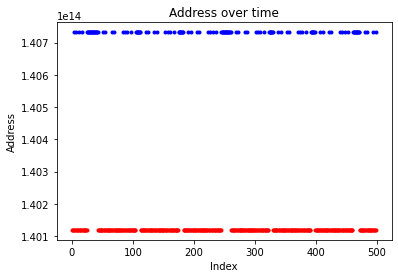

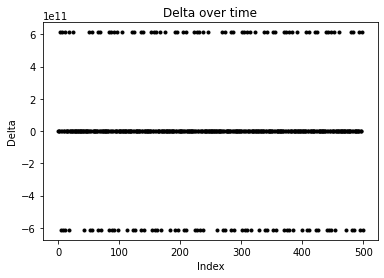

In [35]:
parse_data()
data = get_and_analyze_data(start_perc=0.003, plot=True)

In [36]:
import tensorflow as tf
import os
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.117.136.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.117.136.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Proportion of data in top 5000: 0.72375
>>>> IP:  94602865943828.0 140119319091961.0
>>>> Addr1:  140118976570040.0 140732090279160.0
>>>> Addr2:  94602865942592.0 94602868043752.0
Training X & y:  (26091, 6, 3) (26091, 5000)
Validation X & y:  (2899, 6, 3) (2899, 5000)
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 6, 3)         0                                            
__________________________________________________________________________________________________
lstm_43 (LSTM)                  (None, 6, 128)       67584       input1[0][0]                     
__________________________________________________________________________________________________
dropout_43 (Dropout)            (None, 6, 128)       0           lstm_43[0][0]                    
__________________

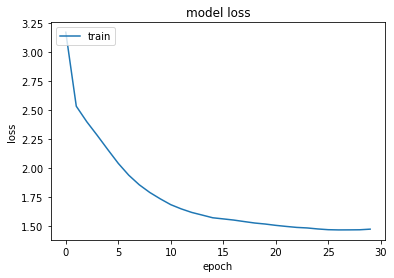

In [41]:
from sklearn.model_selection import train_test_split
import keras

class MyCustomCallback(keras.callbacks.Callback):
  def __init__(self, test_data, k=10):
    self.X_test, self.y_test = test_data
    self.k = k

  def on_train_batch_end(self, batch, logs=None):
    if (batch+1)%200!=0:
      return
    y_test_pred = self.model.predict(self.X_test)
    topk = y_test_pred.argsort()[:, -self.k:]
    acc = 0.
    for i in range(self.y_test.shape[0]):
      if np.argmax(self.y_test[i]) in topk[i]:
        acc += 1.
    print("ACC: ", acc / float(self.y_test.shape[0]))
    

def get_lstm_model(X_train, y_train, X_test, y_test, rnn_units=32, batch_size=64, maxlen=10, num_labels=3, num_classes=3000, epochs=3, toplot=False):
  input_layer1 = keras.layers.Input(shape=(maxlen, 3, ), name='input1')

  #LSTM Layer 1 with Dropout
  lstm_layer1 = keras.layers.LSTM(rnn_units, return_sequences=True)(input_layer1)
  lstm_layer1 = keras.layers.Dropout(0.1)(lstm_layer1)

  #LSTM Layer 2 with Dropout
  lstm_layer2 = keras.layers.LSTM(rnn_units, return_sequences=True)(lstm_layer1)
  lstm_layer2 = keras.layers.Dropout(0.1)(lstm_layer2)

  self_attn1 = SeqSelfAttention(
    attention_width=5,
    attention_activation='sigmoid',
    history_only=True,
    name='SelfAttention1',
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL
  )(lstm_layer2)

  self_attn1 = keras.layers.GlobalMaxPooling1D()(self_attn1)
  lstm_out = keras.layers.Lambda(lambda t: t[:,-1])(lstm_layer2)
  penultimate = keras.layers.Concatenate()([lstm_out, self_attn1])
  #Output Layer
  prediction = keras.layers.Dense(num_classes, activation='softmax')(penultimate)

  #Model Inputs and outputs
  model = keras.models.Model(inputs=input_layer1, outputs=prediction)
  #Use Categorical Loss and Accuracy with Adam Optimizer
  model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print(model.summary())

  #Fit the model to the data
  history = model.fit(X, y, batch_size=batch_size, epochs=epochs, shuffle=False, callbacks=[MyCustomCallback((X_test, y_test), k=3)])

  #Plot the loss curves
  if toplot:
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

  return model

X, y = create_dataset(data, data_cnt=40000, num_classes=5000, maxlen=6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Training X & y: ", X_train.shape, y_train.shape)
print("Validation X & y: ", X_test.shape, y_test.shape)

#Use TPU Strategy
with strategy.scope():
  model = get_lstm_model(X_train, y_train, X_test, y_test, rnn_units=128, batch_size=64, num_classes=5000, maxlen=6, epochs=30, toplot=True)


In [0]:
with open(ROOT_DIR + 'model_for_cpp_self_attn.json', 'w') as fout:
    fout.write(model.to_json())
model.save_weights(ROOT_DIR + 'model_for_cpp_self_attn_weights.h5', overwrite=True)

In [39]:
from typing import List
from sklearn.cluster import KMeans


def prefetch_predict(lastNPCs: List[int], lastNAddrs: List[int], topk: int) -> int:
  def get_cluster_id(center1, center2, point):
    if abs(center1-point) < abs(center2-point):
      return 0
    else:
      return 1

  idx_to_delta = None
  with open(ROOT_DIR + 'delta_idx_map.json') as json_file:
    idx_to_delta = json.load(json_file)

  N = 5
  if len(lastNPCs) != N or len(lastNAddrs) != N:
    return -1

  f = open(ROOT_DIR + "model_for_cpp.json")
  model = tf.keras.models.model_from_json(f.read())
  f.close()

  ip1 = 94602865943828.0
  ip2 = 140119319091961.0

  addr11 = 140118976570040.0
  addr12 = 140732090279160.0

  addr21 = 94602865942592.0
  addr22 = 94602868043752.0

  model.load_weights(ROOT_DIR + "model_for_cpp_weights.h5")
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  
  center1 = 1.40618487e+14
  center2 = 9.46028667e+13
  ips = np.array(lastNPCs)
  ips = [(ip-ip1)/(ip2-ip1) for ip in ips]

  addrs = np.array(lastNAddrs)
  cluster_ids = [get_cluster_id(center1, center2, addr) for addr in addrs]

  for i in range(len(addrs)):
    if cluster_ids[i] == 0:
      addrs[i] = (addrs[i]-addr11) / (addr12-addr11)
    else:
      addrs[i] = (addrs[i]-addr21) / (addr22-addr21)

  X = np.array([list(xx) for xx in zip(ips, cluster_ids, addrs)])
  X = X.reshape(1, N, 3)
  y_pred = model.predict(X)
  topkidxs = y_pred.argsort()[:, -topk:][0]

  return [idx_to_delta[str(idx)] for idx in topkidxs]
  

print(prefetch_predict([9.46887013e-12, 8.85380658e-12, 9.02966590e-12, 9.18332077e-12, 9.31521527e-12],
  [0.99999919, 0.99999919, 0.99999926, 0.99999919, 0.99999919], 10))

[-46129224239908.0, 4525464.0, 613113481496.0, -612768972886.0, 45516455285275.0, 613113566043.0, -613109020900.0, -613113551484.0, -613113565603.0, 344579372.0]
